# Investigating Movie Success

## Introduction
Cinema has become one of the highest profiting industries over the past century. The total box office revenue in North America alone amounted to $11.38 billion in 2016. With the possibility of great success, there is also a large risk of financial failure. This data exploration is motivated by answering the question what makes a movie successful. Specifically do higher budgets mean that a movie will be more profitable? Does the date of release affect the movies profit? Is the box office revenue for the opening weekend of a movie a good predictor of the profit of a movie? Answering these questions could save cinema production companies millions.

## Data Scraped, Downloaded & Cleaned
To begin the data investigation, a collection of movies will be needed to gather data on. To accomplish this, movie names will be scraped from the rotten tomatoes top 100 movies for each genre. There are 17 different genres listed, although some movies are listed in multiple genres, and not every genre contains a full list of 100 movies. In total, after eliminating duplicates, there will be 937 distinct movies collected. The collection of movie names will be biased towards more successful productions, although the large selection will resolve some of the bias introduced by the selection method.

In [1]:
# importing all libraries to be used throughout data exploration
import re, json, requests, seaborn, warnings
warnings.filterwarnings( 'ignore' )
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
from matplotlib import pyplot as plt, rcParams
%matplotlib inline
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException

In [2]:
# This code creates a list of urls containing the top 100 movies for each genre
base_url = "https://www.rottentomatoes.com"
# Start with the action and adventure genre url
a_a = "https://www.rottentomatoes.com/top/bestofrt/top_100_action__adventure_movies/"
# The url compiler below finds urls that contain lists of top 100 movies
url_finder = re.compile( r"/top/bestofrt/top_100_.*$" )
# Below we get the html text for the action and adventure genre page
# This page also contains links to all the other top 100 pages
# The pages that match the url compiler are collected with the find_all
page_source = requests.get( a_a ).text
soup = BeautifulSoup( page_source, "html.parser" )
urls = soup.find_all( "a", href = url_finder )
top = []
#each url for the top 100 movie list is appended to a list to later 
#gather the movie name
for url in urls:
    top.append( base_url + url[ "href" ] )

### Scraping Movie Data
While the movie names are being collected from rotten tomatoes, it is convienent to collect the motion picture content rating and the rotten tomatoes score that was given for the movie and add this to the dataset.

In [39]:
# Initialize a set of all movies so that duplicates are not added
all_movies = []
# Initialize a list for data to be used to create DataFrame
data = []
# For each top 100 movies page 
for url in top:
    # requesting html
    page_source = requests.get( url ).text
    soup = BeautifulSoup( page_source, "html.parser" )
    # top 100 movies are contained in json, load this in as a dict
    top_100 = soup.find( 'script', type = 'application/ld+json' )
    movie_data = json.loads( top_100.text )
    # finding the list of movies in the json dictionary
    list_dict = movie_data[ "itemListElement" ]
    # For each movie listed in top 100
    for top_movies in list_dict:
        # Get the rotten tomatoes page for the movie url listed
        page_source = requests.get( top_movies[ "url" ] ).text
        soup = BeautifulSoup( page_source, "html.parser" )
        # Load the movie data into a dictionary
        movie_data = json.loads( soup.find( 'script', 
                                type = 'application/ld+json' ).text )
        # Grab the name of the movie
        name = movie_data[ "name" ]
        # This one movie causes an error if left as is, so we change the name
        oops ="The Good, the Bad, the Weird (Joheun-nom, Nabbeun-nom, Isanghan-nom)"
        if name == oops :
            name = "The Good, the Bad, the Weird"
        # Only do the following if movie data wasn't already collected
        if name not in all_movies:
            try:    ratings = movie_data[ 'contentRating' ]
            except: ratings = ""
            try:    scorert = movie_data[ 'aggregateRating' ][ 'ratingValue' ]
            except: scorert = np.nan
            # Add name, motion picture content rating, and rotten tomatoes score to data list
            data.append( [ name, ratings, scorert ] )
        # Add movie name to the list of movie names so it is accounted for
        all_movies.append( name )

### Gathering Monetary Information on Each Movie
After accumulating movie names, motion picture content rating, and the rotten tomatoes score, the dataset is still missing information on the movie budget, opening weekend revenue, and gross income, which will provide the numerical data points necessary to understand the factors that make a movie successful. The data points will be collected from IMDB, which is a reputable source for information, according to their website, 

>"we [IMDB] actively gather information from and verify items with studios and 
filmmakers".

While collecting the data points, it will be convient and valuable to find the release date of the movie and add to the dataset.

In [40]:
# url to get to imdb
base_url = "http://www.imdb.com/"
browser = webdriver.Chrome()
browser.get( base_url )
# For each movie thats already been collected
for i in range( len( data ) ):
    # Get the search bar, type in movie name, and press Enter.
    search_bar = browser.find_element_by_id( "navbar-query" )
    # Clear any pre-set text.
    search_bar.clear() 
    # Searching for the name of the movie
    search_bar.send_keys( data[ i ][ 0 ] ) 
    # Press Enter.
    search_bar.send_keys( Keys.RETURN ) 
    soup = BeautifulSoup( browser.page_source, "html.parser" )
    # Look at the search table results and choose the first result
    table = soup.find( name = "table" )
    link = table.find_all( name = "td" )[ 1 ]
    url = base_url + link.find( name = "a" )[ "href" ]
    # Get page for first movie result
    browser.get( url ) 
    soup = BeautifulSoup( browser.page_source, "html.parser" )
    # All information needed is contained in h4 tabs
    tab = soup.find_all( name = "h4" )
    B, O, G, R = False, False, False, False
    for j in tab:
        if j.text == "Release Date:" :
            data[ i ].append( ( " " ).join( j.next_sibling.split() ) )
            R = True
        if j.text == "Budget:":
            data[ i ].append( ( " " ).join( j.next_sibling.split() ) )
            B = True
        if j.text == "Opening Weekend:":
            data[ i ].append( ( " " ).join( j.next_sibling.split( ) ) )
            O = True
        if j.text == "Gross:":
            data[ i ].append( ( " " ).join( j.next_sibling.split( ) ) )
            G = True
    # Inserting NaNs for missing values
    if not R: data[ i ].insert( 3, np.nan )
    if not B: data[ i ].insert( 4, np.nan )
    if not O: data[ i ].insert( 5, np.nan )
    if not G: data[ i ].insert( 6, np.nan )  
browser.close()

### Uncleaned Dataset

In [580]:
n = len( data )
columns = [ "Name", "Rating", "Score", "Release", "Budget", "Open", "Gross" ]
df = pd.DataFrame( data, index = np.arange( n ), columns = columns )
df.sample(3)

,Name,Rating,Score,Release,Budget,Open,Gross
843,Carlos,NR,94,11 October 2010 (USA),NaN,"$20,006 (USA)","$145,118"
51,Guardians of the Galaxy,PG13,91,1 August 2014 (USA),"$170,000,000","PHP 103,157,575 (Philippines)","$333,176,600"
455,The Island President,PG,98,30 March 2012 (UK),NaN,"$13,998 (USA)","$75,233"


## Cleaning Data
After gathering each data point, the data set is complete, although the information is not clean or uniform. The first step to clean up the names and release dates, will be to remove any phrases in parenthesis across the rows of the DataFrame. Following the removal of parenthesis, will be the removal of all commas across each column in the DataFrame. Removing commas will make it easier to convert monetary amounts to ints. Next each date in the Release column will be changed to a pandas date object, which will simplify any calculations that rely on the release date of the movie. Finally each monetary amount will be converted into an int, while creating place holder columns for the currency type of the budget and opening weekend revenue. The gross income column of the movie DataFrame is listed in USD solely, so this value will not need a place holder column for it. The dataset is now cleaned, although the information is not given in uniform units, which will need to be addressed.

In [581]:
df1 = df
def remove_parenthesis( row ):
    """
    Function accepts a pd.Series describing a row of a DataFrame. For each 
    value in the row the string before the first opening parenthesis becomes 
    the new value. The new pd.Series of the row is returned, without any 
    phrases in parenthesis.
    """
    row = [ str( value ).split( "(" )[ 0 ] for value in row ]
    return pd.Series( row )
def remove_comma( row ):
    """
    Function accepts a pd.Series describing a row of a DataFrame. For each 
    value in the row the string is split by commas, then joined without 
    them. The new pd.Series of the row is returned, without commas.
    """
    row = [ ( "" ).join( str( value ).split( "," ) ) for value in row ]
    return pd.Series( row )
def _type( currency ):
    """
    Function accepts a value representing a monetary amount. If the value 
    is a string "nan", then np.nan is returned. If the monetary amount split
    by spaces has length greater than one, then this implies that there is a 
    string, such as AUD, before the monetary amount, this currency indicator 
    will be returned. If the monetary amount split by spaces only consist of 
    one item, that implies a symbol, such as $ is before the monetary amount. 
    This currency indicator will be returned.
    """
    if currency == "nan":
        return np.nan
    currency_indicator = currency.split()
    if len( currency_indicator ) > 1:
        return currency_indicator[ 0 ]
    else:
        return currency[ 0 ]
def _int( currency ):
    """
    Function accepts a value representing a monetary amount. If the value is 
    a string "nan", then np.nan is returned. If the monetary amount split by
    spaces has length greater than one, then this implies that there is a 
    string, such as AUD, before the monetary amount, the monetary amount 
    after the currency indicator will be returned as an int. If the monetary 
    amount split by spaces only consist of one item, that implies a symbol,
    such as $ is before the monetary amount. The monetary amount after the 
    currency indicator will be returned as an int.
    """
    if currency == "nan":
        return np.nan
    currency_amount = currency.split()
    if len( currency_amount ) > 1:
        return int( currency_amount[ 1 ] )
    else:
        return int( currency[ 1: ] )
    
df1      = df1.apply( remove_parenthesis, axis = 1 )
df1      = df1.apply( remove_comma,       axis = 1 )
df1[ 3 ] = df1[ 3 ].apply( lambda x: pd.to_datetime( str( x ) ) )
df1[ 7 ] = df1[ 4 ].apply( _type )
df1[ 8 ] = df1[ 5 ].apply( _type )
df1[ 2 ] = df1[ 2 ].apply( lambda x: float( x )  )
df1[ 4 ] = df1[ 4 ].apply( _int  ) #column 4 units described by column 7
df1[ 5 ] = df1[ 5 ].apply( _int  ) #column 5 units described by column 8
df1[ 6 ] = df1[ 6 ].apply( _int  ) #column 6 is all in USD

### Converting Currency to USD
The next step in unifying the currency units is to convert all monetary amounts into USD. Converting each column to USD will make comparisons valid, and is accomplished by using a dataset which contains the exchange rates for 26 different currencies to USD, for dates throughout the past century. For currencies not listed in USD, the release date of the movie will be used to find the accurate exchange rate to USD, after which the currency will be converted to USD. Once the conversations are calculated, the place holder columns describing the original currency are dropped, resulting in a clean and uniform dataset.

In [582]:
e_r_columns = [ "Dates",   "€",   "£",  "BRL", "CNY", "DKK", "INR", "JPY", 
                  "KRW", "MYR", "MXN",  "NOK", "SEK", "ZAR", "SGD", "CHF", 
                  "TWD", "THB", "VEB", "NBDI", "NMC", "NOI", "AUD", "NZD", 
                  "CAD", "HKD", "LKR" ]
exchange_rates = pd.read_csv( "exchange_rates.csv", 
                             skiprows = [ 0, 1, 2, 4, 5, 6 ] )
exchange_rates.columns = e_r_columns
exchange_rates[ "Dates" ] = exchange_rates[ "Dates" ].apply( 
    lambda x: pd.to_datetime( str( x ) ) )

def change_to_USD(row):
    """
    Function accepts a pd.Series representing a pd.DataFrame row, then 
    changes the budget and opening weekend monetary amount to USD, and
    returns the new updated pd.Series with the correct amounts.
    """
    date = row[ 3 ]
    foreign_budget = row[ 4 ]
    foreign_open   = row[ 5 ]
    indicator_budget = row[ 7 ]
    indicator_open   = row[ 8 ]
    
    if indicator_budget != "$" and indicator_budget != "nan":
        try:
            cur_rate = exchange_rates[ indicator_budget ][ 
                exchange_rates[ "Dates" ] == date ].values[ 0 ]
            row[ 4 ] = int( foreign_budget ) / float( cur_rate )
        except:
            row[ 4 ] = np.nan
    if indicator_open   != "$" and indicator_open   != "nan":
        try:
            cur_rate = exchange_rates[ indicator_open   ][ 
                exchange_rates[ "Dates" ] == date ].values[ 0 ]
            row[ 5 ] = int( foreign_open )  / float( cur_rate )
        except:
            row[ 5 ] = np.nan
    return row

df1 = df1.apply( change_to_USD, axis = 1 )

# Delete currency indicator columns
del df1[ 7 ], df1[ 8 ]
df = df1
df.columns = columns
df.sample( 3 )

,Name,Rating,Score,Release,Budget,Open,Gross
530,Eraserhead,R,91.0,1978-02-03,20000.0,NaN,7000000.0
176,Kung Fu Panda 3,PG,86.0,2016-01-29,145000000.0,41282042.0,143528619.0
411,Dawson City: Frozen Time,NR,100.0,2016-10-02,NaN,15922.0,130526.0


In [550]:
df.to_csv( "Cleaned_Data.csv" )

## Feature Engineering
Some adjustments to the dataset will be needed in order to better understand the data. First it will be beneficial to create a column corresponding to the decades of the movies' release date. A column that identifies the profit of the movie will be crucial in determining the financial success of the movie. To create a Profit column, the budget of the movie will be subtracted from the gross income. Finally, there is one remaining issue to be addressed. Because the movies in the dataset span the past century the monetary amounts are not adjusted for inflation, making them difficult to compare directly. To resolve the disagreement between the monetary amounts, a dataset containing the CPI for each year from 1914 will used to adjust for inflation. The CPI, Consumer Price Index, describes the amount of purchasing power the average consumer has. To account for inflation, the current CPI is divided by the CPI of the year when the movie was released to obtain a ratio of purchasing power. The monetary amounts are multiplied by this ratio, resulting in a new monetary amount corresponding to the approximate amount with today's purchasing power. The budget, opening weekend revenue, gross income, and profit of each movie will be adjusted for inflation, and placed into new columns. With the adjusted inflation columns, relationships between variables may become more apparent.

In [551]:
# Drop columns with missing data
df = df.dropna()
# Calculating the decade for the release date
df[ "Decade" ] = df[ "Release" ].apply( lambda x: ( ( x.year % 1900 ) // 10 ) * 10 + 1900  ) 
df[ "Profit" ] = df[ "Gross" ] - df[ "Budget" ]

# Adjusting for inflation
inflation_rates = pd.read_csv( "inflation_rates.csv", index_col = "Year")
current_CPI = float( inflation_rates[ "November" ].iloc[-1] )
def change_to_current(row):
    """
    Function accepts pd.Series describing a row in pd.DataFrame
    Then creates new columns adjusting for inflation by multiplying by CPI ratio
    Function returns new pd.Series describing row in pd.DataFrame
    """
    year_release  = row[ "Release" ].year
    month_release = row[ "Release" ].month - 1
    value_CPI = float( inflation_rates.loc[ year_release ][ 12 ] )
    if value_CPI == 0 :
        row[ "Budget_Adjusted" ], row[ "Gross_Adjusted"  ] = np.nan, np.nan
        row[ "Open_Adjusted"   ], row[ "Profit_Adjusted" ] = np.nan, np.nan
    else:
        row[ "Budget_Adjusted" ] = row[ "Budget" ] * current_CPI / value_CPI
        row[ "Gross_Adjusted"  ] = row[ "Gross"  ] * current_CPI / value_CPI
        row[ "Open_Adjusted"   ] = row[ "Open"   ] * current_CPI / value_CPI
        row[ "Profit_Adjusted" ] = row[ "Profit" ] * current_CPI / value_CPI
    return row
df = df.apply( change_to_current, axis = 1 )
df.head(3)

,Name,Rating,Score,Release,Budget,Open,Gross,Decade,Profit,Budget_Adjusted,Gross_Adjusted,Open_Adjusted,Profit_Adjusted
0,Mad Max: Fury Road,R,97.0,2015-05-15,150000000.0,5.079641e+06,153636354.0,2010,3636354.0,1.561084e+08,1.598929e+08,5.286498e+06,3.784437e+06
3,Dunkirk,PG13,92.0,2017-07-21,100000000.0,7.729581e+06,188043731.0,2010,88043731.0,1.006845e+08,1.893310e+08,7.782493e+06,8.864643e+07
5,Logan,R,93.0,2017-03-03,97000000.0,8.822384e+06,226277068.0,2010,129277068.0,9.766401e+07,2.278260e+08,8.882778e+06,1.301620e+08


In [552]:
df.to_csv( "Engineered_Data.csv" )

## Visualizing Data
The next step to understanding relationships between different variables is visualizing the data. The first step is to investigate how the data has changed over the past century, and compare the change between variables, which may give some insight into relationships between variables.

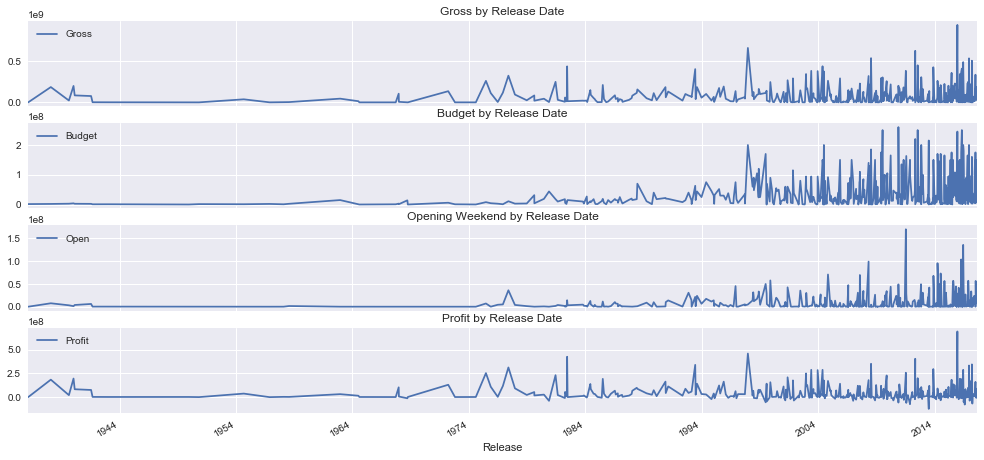

In [573]:
plt.figure( figsize = ( 17, 8 ) )
ax4      = plt.subplot( 414 )
ax1, ax2 = plt.subplot( 411, sharex = ax4 ), plt.subplot( 412, sharex = ax4 )
ax3      = plt.subplot( 413, sharex = ax4 )
df.plot( y = "Gross",  x = "Release", ax = ax1, title = "Gross by Release Date" )
df.plot( y = "Budget", x = "Release", ax = ax2, title = "Budget by Release Date" )
df.plot( y = "Open",   x = "Release", ax = ax3, title = "Opening Weekend by Release Date" )
df.plot( y = "Profit", x = "Release", ax = ax4, title = "Profit by Release Date" )
plt.show()

After observing the graph above, it is apparrent there has been an exponential increase in movie budgets, opening weekend revenues, gross income and profit. It is still unclear how much of this increase is due to inflation over time. Investigating how inflation has changed these four variables is the next rational step.

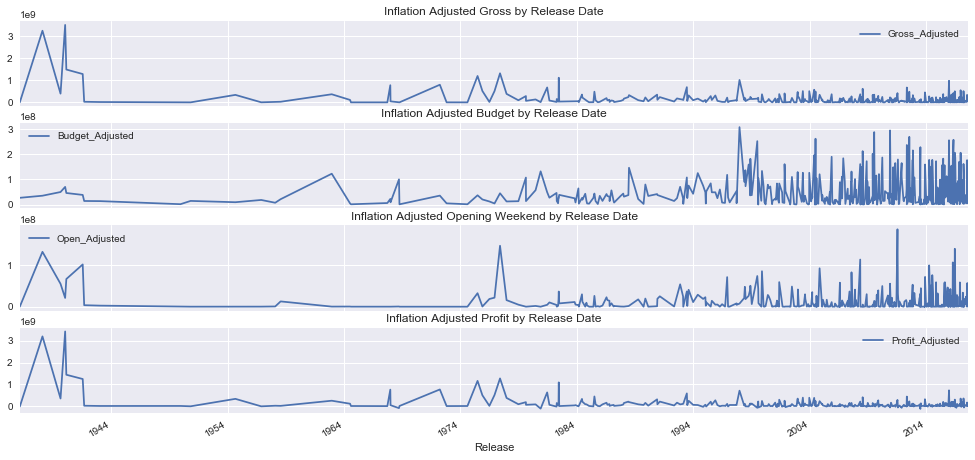

In [575]:
plt.figure( figsize = ( 17, 8 ) )
ax4      = plt.subplot( 414 )
ax1, ax2 = plt.subplot( 411, sharex = ax4 ), plt.subplot( 412, sharex = ax4 )
ax3      = plt.subplot( 413, sharex = ax4 )
df.plot( y = "Gross_Adjusted",  x = "Release", ax = ax1, 
        title = "Inflation Adjusted Gross by Release Date" )
df.plot( y = "Budget_Adjusted", x = "Release", ax = ax2, 
        title = "Inflation Adjusted Budget by Release Date" )
df.plot( y = "Open_Adjusted",   x = "Release", ax = ax3, 
        title = "Inflation Adjusted Opening Weekend by Release Date" )
df.plot( y = "Profit_Adjusted", x = "Release", ax = ax4, 
        title = "Inflation Adjusted Profit by Release Date" )
plt.show()

Looking at the variables in the graphs above, it looks as though the the gross income and profit have decreased over time, while the opening weekend revenue and budget have increased over time. It is important to note that there are significantly more movies released in later decades, as demonstrated in the histogram below. 

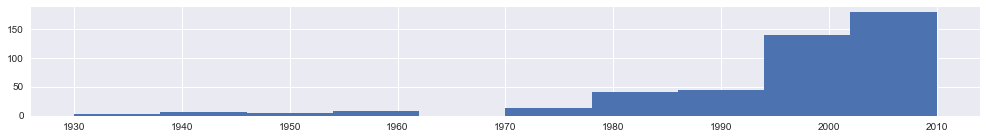

In [570]:
df["Decade"].hist( figsize = ( 17, 2 ) )
plt.show()

It is interesting to note that the movie with the highest adjusted budget was Titanic, the movie with the highest opening weekend revenue was Harry Potter and the Deathly Hallows - Part 2 and the movie with both the highest gross income and profit was Gone with the Wind. After looking at how the monetary variables are distributed over the past century, it seems reasonable to investigate how the variables are correlated.

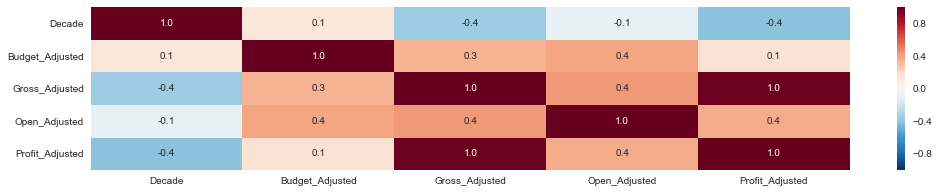

In [553]:
plt.figure( figsize = ( 17,3 ) )
seaborn.heatmap( df[["Decade", "Budget_Adjusted", "Gross_Adjusted", "Open_Adjusted", 
                     "Profit_Adjusted"]].corr(), annot = True, fmt = ".001f" )
plt.show()

The heatmap above gives the strengths of the correlations coefficients, on a scale of -1.0 to 1.0. 1.0 is perfectly positively correlated, and -1.0 is perfectly negatively correlated, meaning each variable will positively correlate to itself perfectly. The heatmap gives some interesting relationships between variables. There were no strong correlations between the unadjusted variables, and thus were excluded from the heatmap above. The first relationship worth notice, is that the later in the century a movie was produced, the worse the adjusted profit and adjusted gross income of the movie would be. A second relationship that needs investigation is the perfect positive correlation between the adjusted gross and the adjusted profit. Since the adjusted profit is calculated from the adjusted gross income, it is reasonable that they would be strongly positively correlated, although extremely unlikely that this would be a perfect relationship. The correlation coefficient for the relationship between the adjusted gross income and the adjusted profit is 0.978601533586, which is strongly positive, although not perfect, as the rounded number in the heatmap would suggest. It is interesting to note that from this heatmap, it seems as though the adjusted budget has little correlation to the adjusted profit. The relationships between the adjusted profit for a movie, and the adjusted budget, adjusted gross income, and adjusted opening weekend revenue still need to be investigated. There may be some intuition to gain from looking at the linear regression for each relationship, which would be the next step in the data exploration.

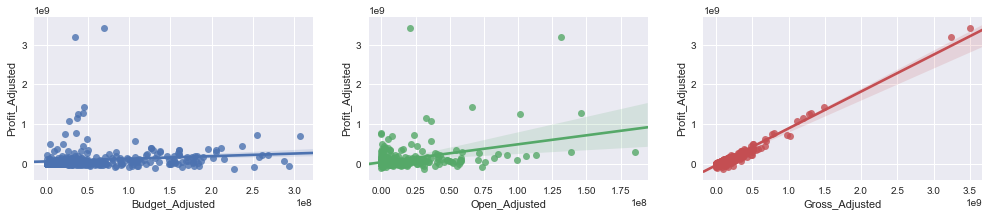

In [564]:
plt.figure( figsize = ( 17,3 ) )
ax1 = plt.subplot( 131 )
ax2, ax3 = plt.subplot( 132, sharey = ax1 ), plt.subplot( 133, sharey = ax1 )
seaborn.regplot( x = "Budget_Adjusted", y ="Profit_Adjusted", ax = ax1, data = df ) 
seaborn.regplot( x = "Open_Adjusted",   y ="Profit_Adjusted", ax = ax2, data = df ) 
seaborn.regplot( x = "Gross_Adjusted",  y ="Profit_Adjusted", ax = ax3, data = df ) 
plt.show()

From the graphs above, it is clear that the gross income is the best estimator for the profit, mainly because profit is calculated from the gross income. However the gross income is only useful to estimate the profit, if the variable for the budget is not available. The second best variable for predicting the profit is the opening weekend revenue. The opening weekend revenue may be a more useful predictor for profit than the gross income, because it can give insight into what the profit of a movie may be before it leaves theaters. It is interesting that there is almost no correlation between the budget of a movie, and the profit the movie makes.

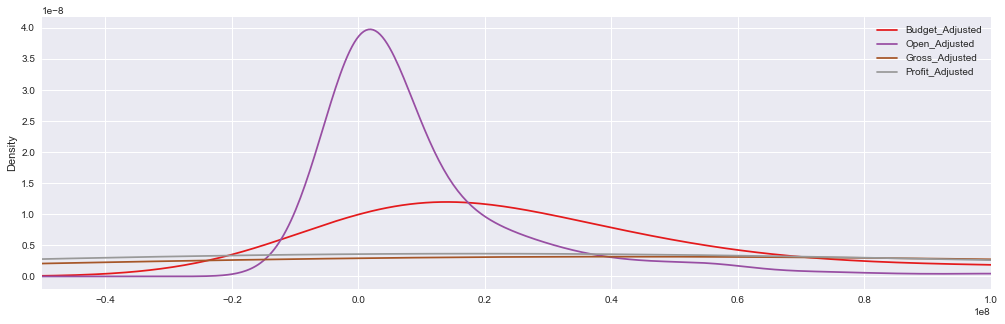

In [559]:
df[["Budget_Adjusted","Open_Adjusted","Gross_Adjusted","Profit_Adjusted"]].plot( 
    kind = "kde", colormap='Set1', figsize = (17,5) )
plt.xlim(-.5e8,1e8)
plt.show()

Looking at the distributions above we can see that there is a large variance between the adjusted gross income and the adjusted profit, with almost not peak. Whereas, the adjusted budget and the adjusted open weekend revenue are less varied distributions. The adjusted budget has little or no correlation to the adjusted profit, which suggests that the regardless of the budget of a movie, there is still a high risk to lose alot of money.

## Conclusion
Unfortunately there does not seem to be a large correlation between the budget of a movie, and the profit of the production. This suggests that spending large amounts of money on a movie production does not necessarily pay off.  After looking into all the dataset variables, there was little information to be gained from the motion picture content rating, the rotten tomatoes score, and the unadjusted monetary amounts. One of the most useful predictors for the profit of a movie seems to be the opening weekend revenue, which is intuitive. A larger dataset of movies could present more correlations, due to time constraints this dataset was limited to ~1000 movie titles.  More information that could be used as predictors for the profit of a movie would be money and time spent into marketing the movie, and the amount of different trailers released. These variables may play a larger role and factor into what makes a movie more profitable and successfull. Also, collecting information on DVD sales once the movie left the theater could give more insight into just how profitable, or successful the movie was.